# Running the Kalibr multicam dataset

This notebook demonstrates the calibration of a stereo pair using the [5-parameter OpenCV camera model](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html). We use the Kalibr multi-camera calibration dataset. Data can be found [here](https://github.com/ethz-asl/kalibr/wiki/downloads). To run this notebook locally, be sure to populate the full path to your copy of `cam_april.bag` and `april_6x6.yaml`.

In [ ]:
bag_path = '/path/to/cam_april.bag'
chart_definition_path = '/path/to/april_6x6.yaml'

In [2]:
# Standard imports
from collections import defaultdict
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.spatial.transform import Rotation as R
from typing import Dict, List, Tuple

# ROS imports
import rosbag
import cv_bridge
from sensor_msgs.msg import Image

# Calico
import calico

In [3]:
def DrawErrorStats(
    measurement_residual_pairs: List[Tuple[calico.CameraMeasurement, np.ndarray]]
):
    # Compute all residual magnitudes.
    residual_norms = np.array([np.linalg.norm(residual) for _, residual in measurement_residual_pairs])
    # Get historgram of residuals and compute a cumulative density function.
    counts, bins = np.histogram(residual_norms, bins=70)
    cdf = np.cumsum(np.insert(counts, 0, 0)) / np.sum(counts)
    three_sigma = np.argmax(cdf > 0.997)

    # Compute RMSE on a per-frame basis.
    image_id_to_residuals = defaultdict(list)
    for measurement, residual in measurement_residual_pairs:
        image_id = measurement.id.image_id
        image_id_to_residuals[image_id].append(residual)
    image_id_to_rmse = {}
    for image_id, residuals in image_id_to_residuals.items():
        residuals_np = np.array(residuals)
        image_id_to_rmse[image_id] = np.sqrt(np.sum(residuals_np**2) / residuals_np.size)

    # Compute the cumulative RMSE of local regions of the image.
    height, width = 480, 752                                                                                                                                                      
    rmse_heatmap_image, _, _ = calico.ComputeRmseHeatmapAndFeatureCount(
        measurement_residual_pairs, image_width = width, image_height = height)

    # Plot the CDF of the errors as well as a time-series plot of RMSE per frame.
    plt.figure(figsize=(18, 4))
    plt.subplot(1, 3, 1)
    plt.plot(bins, cdf)
    plt.plot([bins[three_sigma]]*2, [-0.1, 1.1], 'k--', label='3-\sigma')
    plt.plot([bins[three_sigma], bins[three_sigma] + 0.3],
             [cdf[three_sigma], cdf[three_sigma] - 0.1], 'r-')
    plt.text(bins[three_sigma] + 0.3, cdf[three_sigma] - 0.1,
             f'99.7% of detections have < {bins[three_sigma]:.2f}px error')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, np.max(residual_norms)])
    plt.ylabel('CDF of residual norms')
    plt.xlabel('Residual magnitude [px]')
    plt.legend()
    plt.grid('on')
    plt.subplot(1, 3, 2)
    image_id_sorted = np.array(sorted(image_id_to_rmse.keys()))
    rmse_sorted = np.array([image_id_to_rmse[m_id] for m_id in image_id_sorted])
    plt.plot(image_id_sorted, rmse_sorted, 'k-')
    plt.grid('on')
    plt.xlabel('Image ID')
    plt.ylabel('RMSE')
    plt.subplot(1, 3, 3)
    plt.imshow(rmse_heatmap_image)
    plt.title('RMSE heatmap')
    plt.clim(0, 1.0)
    plt.colorbar(shrink=0.75)

def DrawImageAndRoi(
    all_images: Dict[str, Dict[int, np.ndarray]], image_topic: str,
    measurement_residual_pairs: List[Tuple[calico.CameraMeasurement, np.ndarray]],
    target_image_id: int, xlims: List[int], ylims: List[int],
    draw_detections=True, draw_reprojections=True
) -> None:
    detection_color, reprojection_color = 'lime', 'magenta'
    detection_size, reprojection_size = 5, 5
    measurements_at_frame = []
    reprojections_at_frame = []
    for measurement, residual in measurement_residual_pairs:
        if measurement.id.image_id == target_image_id:
            measurements_at_frame.append(measurement.pixel)
            reprojections_at_frame.append(measurement.pixel - residual)
    measurements_at_frame = np.array(measurements_at_frame)
    reprojections_at_frame = np.array(reprojections_at_frame)
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.imshow(all_images[image_topic][target_image_id], cmap='gray')
    if draw_detections:
        plt.plot(measurements_at_frame[:,0], measurements_at_frame[:,1],
                 color=detection_color, marker='.', linestyle='',
                 label='detection', markersize=detection_size)
    if draw_reprojections:
        plt.plot(reprojections_at_frame[:,0], reprojections_at_frame[:,1],
                 color=reprojection_color, marker='.', linestyle='',
                 label='reprojection', markersize=reprojection_size)
    plt.plot([xlims[0], xlims[1], xlims[1], xlims[0], xlims[0]],
             [ylims[0], ylims[0], ylims[1], ylims[1], ylims[0]], 'r-')
    plt.legend()
    plt.subplot(1,2,2)
    plt.imshow(all_images[image_topic][target_image_id], cmap='gray')
    if draw_detections:
        plt.plot(measurements_at_frame[:,0], measurements_at_frame[:,1],
                 color=detection_color, marker='.', linestyle='',
                 label='detection', markersize=detection_size)
    if draw_reprojections:
        plt.plot(reprojections_at_frame[:,0], reprojections_at_frame[:,1],
                 color=reprojection_color, marker='.', linestyle='',
                 label='reprojection', markersize=reprojection_size)
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.gca().invert_yaxis()

# Parse data

We start by parsing the data. `Kalibr` uses an in-house visual fiducial called [Aprilgrid](https://github.com/ethz-asl/kalibr/wiki/calibration-targets). Calico comes with a copy of `Kalibr`'s Aprilgrid detector along with python bindings. Here, we go through every image in the rosbag, run an Aprilgrid detection, then store those detections in a dictionary.

In [4]:
# Read in the rosbag and create an Aprilgrid chart detector.
bag = rosbag.Bag(bag_path, 'r')
detector = calico.AprilGridDetector(chart_definition_path)

# Extract Aprilgrid detections from images.
topic_left = '/cam0/image_raw'
topic_right = '/cam1/image_raw'
all_detections = {
    topic_left: [],
    topic_right: [],
}
all_images = {
    topic_left: {},
    topic_right: {},
}
total_expected_messages = \
    bag.get_message_count(topic_left) + bag.get_message_count(topic_right)
bridge = cv_bridge.CvBridge()
for msg_count, (topic, msg, stamp) in enumerate(bag.read_messages(topics = [topic_left, topic_right])):
    print(f'\r{(100.0 * msg_count + 1) / total_expected_messages:.1f}%:'
          f' Processed {msg_count + 1} of {total_expected_messages} images.', end='')
    cv_img = bridge.imgmsg_to_cv2(msg, desired_encoding = 'passthrough')
    all_images[topic][msg.header.seq] = cv_img.copy()
    detections = detector.Detect(cv_img)
    if len(detections) < 28:
      continue
    all_detections[topic].append(
        (msg.header.stamp.to_sec(), msg.header.seq, detections))
bag.close()

100.0%: Processed 2899 of 2899 images.

# Create `WorldModel`

We need the physical definitions of the fiducial corners. In this case, we grab the model definition from the detector and get it as a `RigidBody`. `WorldModel` is capable of holding multiple `RigidBody` definitions, but our problem only has one, i.e. the Aprilgrid chart.

In [5]:
chart_rigid_body = detector.GetRigidBodyDefinition()
chart_rigid_body.world_pose_is_constant = True
chart_rigid_body.model_definition_is_constant = True
world_model = calico.WorldModel()
world_model.AddRigidBody(chart_rigid_body)

# Create `Camera`'s
Next, we populate camera objects with the appropriate information. Given the current set of detections, we obtain a ballpark guess at each camera's pinhole parameters. This guess will be used to initialize the intrinsics parameters.

In [6]:
# Estimate the pinhole parameters for the left and right cameras. Also estimate
# the left camera's trajectory with respect to the chart.
left_detections = [detections[2] for detections in all_detections[topic_left]]
intrinsics_left, R_chart_left, t_chart_left = calico.InitializePinholeAndPoses(
    left_detections, chart_rigid_body.model_definition)
right_detections = [detections[2] for detections in all_detections[topic_right]]
intrinsics_right, _, _ = calico.InitializePinholeAndPoses(
    right_detections, chart_rigid_body.model_definition)

# Parse the estimated intrinsics and average them since the cameras are similar.
# We are initializing with an isotropic focal length and no skew, i.e.
# K = [f 0 cx]
#     [0 f cy]
#     [0 0  1]
f = np.mean([
intrinsics_left[0], intrinsics_left[1],
intrinsics_right[0], intrinsics_right[1]])
cx = np.mean([intrinsics_left[3], intrinsics_right[3]])
cy = np.mean([intrinsics_left[4], intrinsics_right[4]])
initial_intrinsics = [f, cx, cy, 0, 0, 0, 0, 0]

# Create our camera objects and populate their information.
camera_left = calico.Camera()
camera_left.SetName(topic_left)
for stamp, seq, detections in all_detections[topic_left]:
    measurements = calico.DetectionsToCameraMeasurements(detections, stamp, seq)
    camera_left.AddMeasurements(measurements)
camera_left.SetModel(calico.CameraIntrinsicsModel.kOpenCv5)
camera_left.SetIntrinsics(initial_intrinsics)

camera_right = calico.Camera()
camera_right.SetName(topic_right)
for stamp, seq, detections in all_detections[topic_right]:
    measurements = calico.DetectionsToCameraMeasurements(detections, stamp, seq)
    camera_right.AddMeasurements(measurements)
camera_right.SetModel(calico.CameraIntrinsicsModel.kOpenCv5)
camera_right.SetIntrinsics(initial_intrinsics)

# Create Sensor Rig `Trajectory`

Initializing the pinhole parameters for the left camera also provided us with its pose relative to the calibration chart. We model this problem as a camera moving in front of a stationary chart, and use those camera poses directly in the construction of our `Trajectory` object.

In [7]:
stamps = [detections[0] for detections in all_detections[topic_left]]
poses_chart_sensorrig = {}
for stamp, R_chart_left_i, t_chart_left_i in\
  zip(stamps, R_chart_left, t_chart_left):
    pose_chart_sensorrig = calico.Pose3d()
    pose_chart_sensorrig.rotation = \
      R.from_matrix(R_chart_left_i).as_quat()[[3, 0, 1, 2]]
    pose_chart_sensorrig.translation = t_chart_left_i
    poses_chart_sensorrig[stamp] = pose_chart_sensorrig
trajectory_chart_sensorrig = calico.Trajectory()
trajectory_chart_sensorrig.FitSpline(poses_chart_sensorrig, knot_frequency=10)

# Calibrate

We're done setting up our problem. Now we create a `BatchOptimizer` object, add the `WorldModel`, `Trajectory`, and `Camera` objects to the optimizer, and run an optimization to completion.

In [8]:
# Print our intrinsics and extrinsics prior to optimization.
print('---------------------------------------------------------')
print('Intial intrinsics: ')
print(f'{camera_left.GetName()}:')
print(f'{camera_left.GetIntrinsics()}')
print(f'{camera_right.GetName()}:')
print(f'{camera_right.GetIntrinsics()}')
print('Initial extrinsics: ')
print(f'{camera_right.GetName()}:')
print(f' q - {camera_right.GetExtrinsics().rotation}, t - {camera_right.GetExtrinsics().translation}')
print('Initial latency: ')
print(f'{camera_right.GetName()}: {camera_right.GetLatency()}')

---------------------------------------------------------
Intial intrinsics: 
/cam0/image_raw:
[593.33275266 350.01289069 204.33745359   0.           0.
   0.           0.           0.        ]
/cam1/image_raw:
[593.33275266 350.01289069 204.33745359   0.           0.
   0.           0.           0.        ]
Initial extrinsics: 
/cam1/image_raw:
 q - [1. 0. 0. 0.], t - [0. 0. 0.]
Initial latency: 
/cam1/image_raw: 0.0


In [9]:
# Configure the sensors for estimation.
camera_left.EnableIntrinsicsEstimation(True)
camera_left.EnableExtrinsicsEstimation(False)
camera_left.EnableLatencyEstimation(False)
camera_left.SetLossFunction(calico.LossFunctionType.kCauchy, 1.0)
camera_right.EnableIntrinsicsEstimation(True)
camera_right.EnableExtrinsicsEstimation(True)
camera_right.EnableLatencyEstimation(True)
camera_right.SetLossFunction(calico.LossFunctionType.kCauchy, 1.0)

# Create optimizer and add everything
optimizer = calico.BatchOptimizer()
optimizer.AddSensor(camera_left)
optimizer.AddSensor(camera_right)
optimizer.AddWorldModel(world_model)
optimizer.AddTrajectory(trajectory_chart_sensorrig)

# Configure solver and run optimization.
options = calico.DefaultSolverOptions()
options.num_threads = 4
options.minimizer_progress_to_stdout = False
summary = optimizer.Optimize(options)

In [10]:
# Print results.
print('---------------------------------------------------------')
print('Final intrinsics: ')
print(f'{camera_left.GetName()}:')
print(f'{camera_left.GetIntrinsics()}')
print(f'{camera_right.GetName()}:')
print(f'{camera_right.GetIntrinsics()}')
print('Final extrinsics: ')
print(f'{camera_right.GetName()}:')
print(f' q - {camera_right.GetExtrinsics().rotation}, t - {camera_right.GetExtrinsics().translation}')
print(f'Final latency:')
print(f'{camera_right.GetName()}: {camera_right.GetLatency()}')
print('---------------------------------------------------------')
print('Final RMSE')
print(np.sqrt(summary.final_cost / summary.num_residuals))

---------------------------------------------------------
Final intrinsics: 
/cam0/image_raw:
[ 4.57549861e+02  3.67104077e+02  2.48960265e+02 -3.07518531e-01
  1.25482896e-01  1.55691562e-04 -2.20463206e-04 -2.76214424e-02]
/cam1/image_raw:
[ 4.56298509e+02  3.80445427e+02  2.56014390e+02 -3.04211629e-01
  1.19968763e-01 -1.06532735e-04 -2.59027664e-04 -2.51522014e-02]
Final extrinsics: 
/cam1/image_raw:
 q - [9.99975621e-01 6.87533956e-03 4.95534734e-04 1.11411893e-03], t - [ 0.11030172 -0.00020546  0.00048853]
Final latency:
/cam1/image_raw: -4.279248452569076e-05
---------------------------------------------------------
Final RMSE
0.20979504646169556


# Success...?
The problem converged, which is great. Furthermore, the `Kalibr` toolbox also gives similar results (at least for the pinhole parameters), giving us a good baseline:
```
       Kalibr       Calico
fx:  458.824305   457.549861    
fy:  457.542581   457.549861
cx:  366.398392   367.104077
cy:  248.699508   248.960265
```
But which one is right? If the parameters are similar enough, **does it matter**?


There's only one way to find out, and that's to look deeper into the final residuals. To start, let's look at the final root-mean-squared error, or RMSE. Preliminary results yielded an RMSE of 0.21 pixels. The detection noise of the fiducial corners is typically between 0.05 and 0.1 pixels, so an ideal calibration would yield an RMSE close to that. Generally speaking, a sub-pixel RMSE can be considered "passing", but this error is not ideal. We can dive deeper into the results to see what's wrong.

In the next step, we parse the measurements and residuals from the left camera and examine their nature.

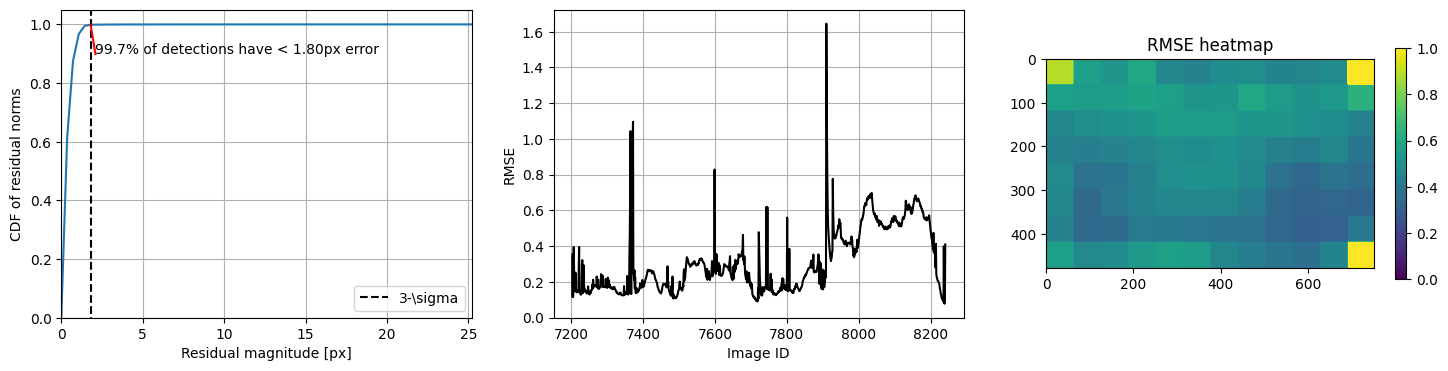

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

DrawErrorStats(camera_left.GetMeasurementResidualPairs())

# First impressions

## Plot 1:
* The CDF indicates that we have residuals that are over 25px in size. This implies outliers.

## Plot 2:
* Spikes in the RMSE-per-frame plot reinforces the outliers hypothesis.
* Between frames 7200 to about 7850, the RMSE hovers around 0.2px which is a sign of underfitting or poor model selection.
* Between frames 7850 to about 8200, the RMSE's bias increases to roughly 0.6px indicating a change in detection quality.

## Plot3:
* High RMSE in the image corners reinforces the underfitting hypothesis.

## Summary:
* The 5-parameter OpenCV camera model might not be a great fit for this camera.
* There are probably outliers.
* Fiducial detections might not be consistent throughout the dataset.

In the next cell, we look for evidence of each of these hypotheses.

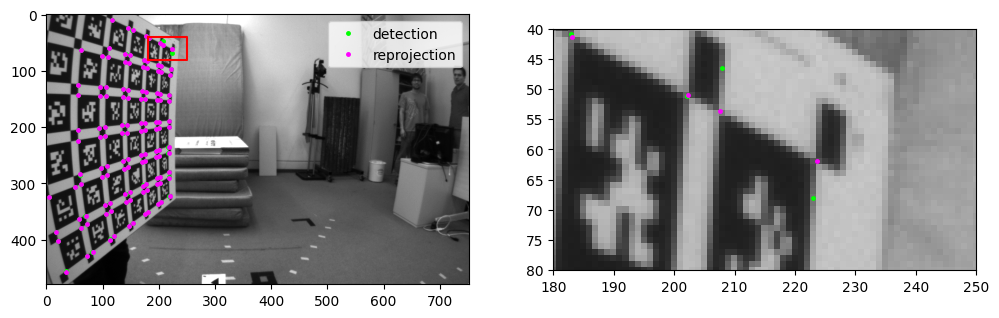

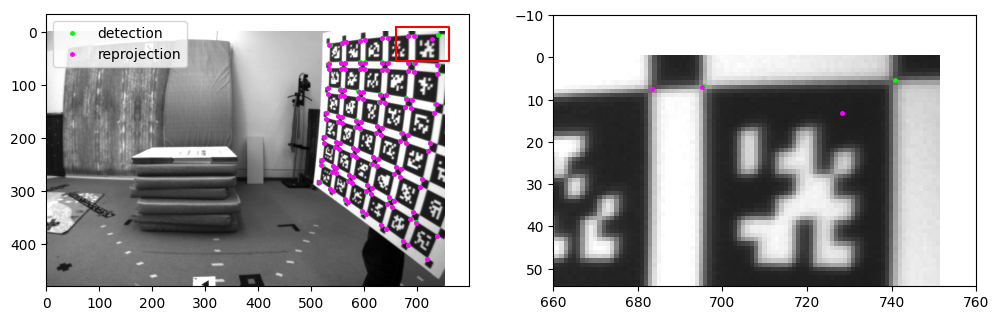

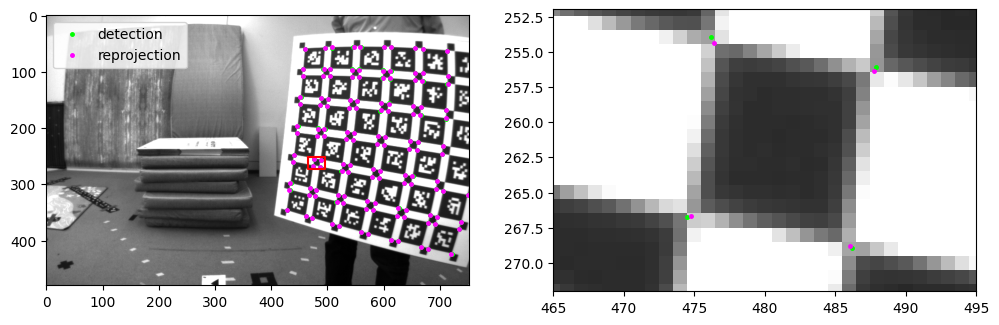

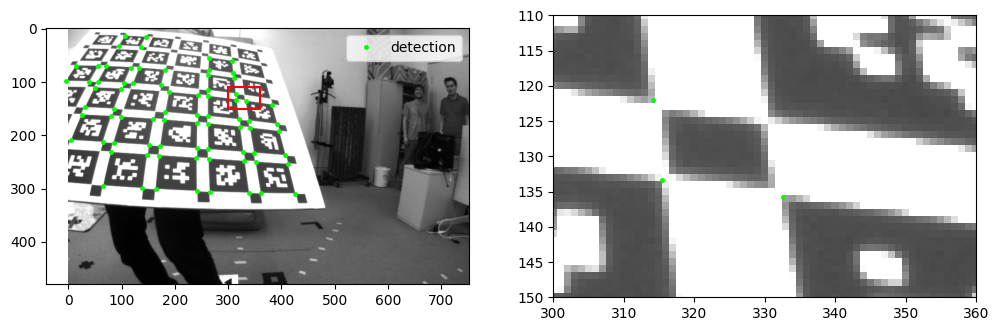

In [12]:
%matplotlib inline

# Select an image with an RMSE spike and display it with its detections.
measurement_residual_pairs = camera_left.GetMeasurementResidualPairs()
DrawImageAndRoi(all_images, topic_left, measurement_residual_pairs, target_image_id=7743,
                xlims=[180, 250], ylims=[40, 80], draw_detections=True, draw_reprojections=True)
# Select another image with an RMSE spike and display it with its detections.
DrawImageAndRoi(all_images, topic_left, measurement_residual_pairs, target_image_id=7912,
                xlims=[660,760], ylims=[-10,54], draw_detections=True, draw_reprojections=True)
# Select an image within the 7200-7850 range and display it with its detections.
DrawImageAndRoi(all_images, topic_left, measurement_residual_pairs, target_image_id=7870,
                xlims=[465, 495], ylims=[252, 272], draw_detections=True, draw_reprojections=True)
# Select an image within the 7850-8200 range and display it.
DrawImageAndRoi(all_images, topic_left, measurement_residual_pairs, target_image_id=8025,
                xlims=[300, 360], ylims=[110, 150], draw_detections=True, draw_reprojections=False)

# Updating our calibration problem

We've confirmed our suspicions.
1. The top row shows the existence of outliers in the dataset.
2. The two middle rows show that detections near the corners are not accurately represented by the distortion model, and they are biasing reprojections near the image center.
3. The bottom row shows that starting at frame 7850, the calibration target is tilted upwards causing the fiducials to be washed out by harsh lighting, resulting in inaccurate detections.

We'll resolve these issues with the following steps:
1. Mark all images after 7850 as "outliers", thus excluding them from the optimization.
2. Switch both cameras over to the Kannala-Brandt "fisheye" model and run an optimization to get ballpark results.
3. Mark all residuals bigger than 3 pixels as outliers and run a final refinement optimization.

**NOTE: Excluding large chunks of data is usually not a good idea. If you do not have clean data, it is imperative that you fix whatever environmental or mechanical issues the data may suffer from. Here, I exclude these detections for demonstration purposes only.**

In [13]:
# Switch camera models.
intrinsics_left = camera_left.GetIntrinsics()
intrinsics_right = camera_right.GetIntrinsics()
camera_left.SetModel(calico.CameraIntrinsicsModel.kKannalaBrandt)
camera_left.SetIntrinsics(np.concatenate((intrinsics_left[:3], np.zeros(4))))
camera_right.SetModel(calico.CameraIntrinsicsModel.kKannalaBrandt)
camera_right.SetIntrinsics(np.concatenate((intrinsics_right[:3], np.zeros(4))))

# Get rid of all measurements from after frame 7850.
measurement_residual_pairs_right = camera_right.GetMeasurementResidualPairs()
ids_to_exclude_right, ids_to_exclude_left = list(), list()
for measurement, _ in measurement_residual_pairs_right:
    if measurement.id.image_id > 7850:
        ids_to_exclude_right.append(measurement.id)
for measurement, _ in measurement_residual_pairs:
    if measurement.id.image_id > 7850:
        ids_to_exclude_left.append(measurement.id)
camera_left.MarkOutliersById(ids_to_exclude_left)
camera_right.MarkOutliersById(ids_to_exclude_right)

# Run optimization to get ballpark intrinsics.
summary = optimizer.Optimize(options)

# Get rid of actual outliers.
measurement_residual_pairs_right = camera_right.GetMeasurementResidualPairs()
measurement_residual_pairs_left = camera_left.GetMeasurementResidualPairs()
ids_to_exclude_right, ids_to_exclude_left = list(), list()
for measurement, residual in measurement_residual_pairs_right:
    if np.linalg.norm(residual) > 3:
        ids_to_exclude_right.append(measurement.id)
for measurement, residual in measurement_residual_pairs_left:
    if np.linalg.norm(residual) > 3:
        ids_to_exclude_left.append(measurement.id)
camera_left.MarkOutliersById(ids_to_exclude_left)
camera_right.MarkOutliersById(ids_to_exclude_right)

# Run final refinement optimization.
summary = optimizer.Optimize(options)

In [14]:
print('---------------------------------------------------------')
print('Final intrinsics: ')
print(f'{camera_left.GetName()}:')
print(f'{camera_left.GetIntrinsics()}')
print(f'{camera_right.GetName()}:')
print(f'{camera_right.GetIntrinsics()}')
print('Final extrinsics: ')
print(f'{camera_right.GetName()}:')
print(f'q - {camera_right.GetExtrinsics().rotation}, t - {camera_right.GetExtrinsics().translation}')
print(f'Final latency:')
print(f'{camera_right.GetName()}: {camera_right.GetLatency()}')
print('---------------------------------------------------------')
print('Final RMSE')
print(np.sqrt(summary.final_cost / summary.num_residuals))

---------------------------------------------------------
Final intrinsics: 
/cam0/image_raw:
[ 4.57289026e+02  3.65831778e+02  2.48848429e+02 -3.16346544e-03
  4.08854709e-02 -5.34498200e-02  2.34848287e-02]
/cam1/image_raw:
[ 4.55801190e+02  3.79278963e+02  2.55684201e+02  4.70232149e-03
  1.96449612e-02 -3.20713278e-02  1.76763217e-02]
Final extrinsics: 
/cam1/image_raw:
q - [9.99974358e-01 7.04492647e-03 6.49850202e-04 1.10919003e-03], t - [ 0.11024742 -0.00029335  0.00055315]
Final latency:
/cam1/image_raw: 5.903227707355734e-05
---------------------------------------------------------
Final RMSE
0.13774417236394795


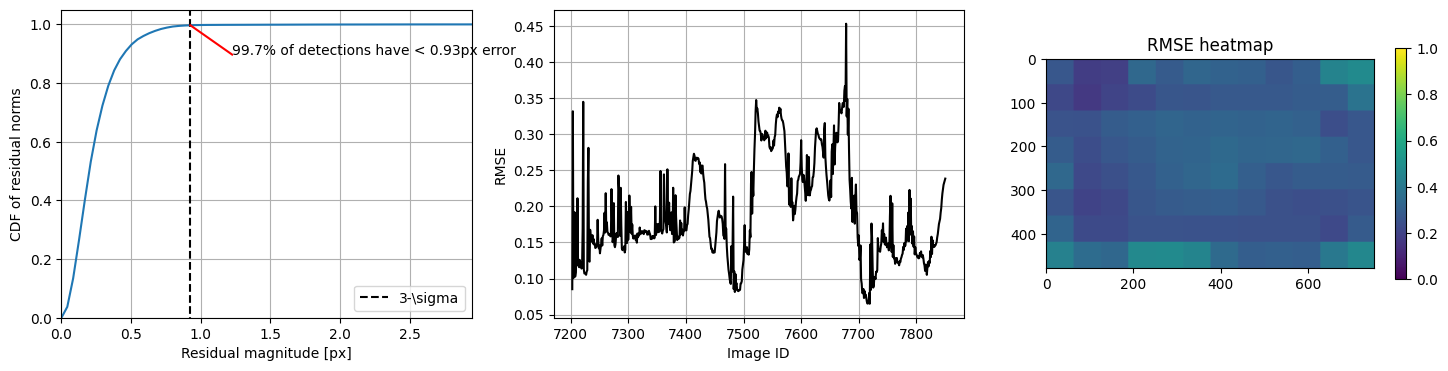

In [16]:
%matplotlib inline
DrawErrorStats(camera_left.GetMeasurementResidualPairs())

# Conclusion
After our modifications, we get a final RMSE of 0.138px. Our baseline estimate is roughly 11cm which is the expected value. Our RMSE heatmap looks more sane, and our per-frame RMSE values are all sub-half-pixel. We processed a significant amount of data in a relatively short amount of time, all with just a few lines of python.